In [1]:
import numpy as np 
import networkx as nx

import matplotlib.pyplot as plt

# Working with Graphs: The Sparse Graph Representation and Scatter-Gather Paradigm

In order to efficiently work with graph-structured data, we (and the field) commonly employ a set of techniques/representations that are not as common as what you would be familiar with if you have worked with images, tabular, or text data. In this notebook, we will introduce you to the Sparse Graph Representation and the Scatter-Gather Paradigm: these are two key concepts that will enable you to start working with large graph datasets and implementing efficient graph neural networks. 

## Motivating the Sparse Graph Representation

A graph has nodes, and edges between those nodes. Additionally, our graphs will have data associated with nodes and edges. For example, our nodes will often represent atoms. Every atom has a position in space. Therefore, every node has associated with it a 3D position, which is a vector of shape `(3,)` or we may say the position of the $i^{th}$ node is $x_i \in \mathbb{R}^3$. 

We'll start with the graph representation you *shouldn't use* when building graph learning systems. I'm going to call this call the **dense graph representation** (I don't know if there is an official term, but that's what I'm going to call it.).  


## Dence Representations (The good ol' fashioned adjacency matrix)

When we ask the question: how do I numerically encode a graph? A classic answer is to use an **adjacency matrix**. For a graph with $N$ nodes, an adjacency matrix $A$ is a matrix of shape `(N, N)`.

$$
A \in \mathbb{R}^{N \times N}
$$

And the adjacency matrix has the following form:

$$
% \[
A_{ij} = 
\begin{cases} 
1 & \text{if there is an edge between node } i \text{ and node } j \\
0 & \text{otherwise}
\end{cases}
% \]
$$


Number of nodes: 4
Shape of the adjacency matrix: (4, 4)
There are 7 edges in the graph
On average, each node is connected to 1.75 other nodes
Adjacency Matrix:
[[0 0 1 1]
 [1 1 0 1]
 [1 0 1 0]
 [0 0 0 0]]


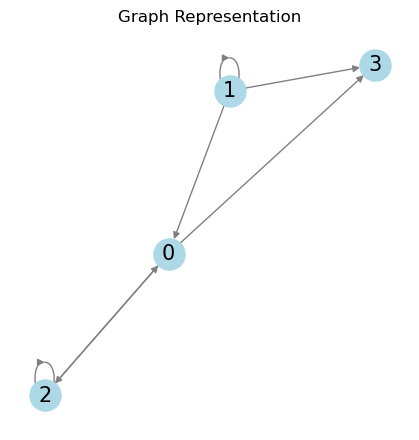

In [189]:
# Define the number of nodes
N = 4

# Create a random adjacency matrix
# we will assume we're wokring with a directed graph
# A_{ij} is an edge starting at node i and ending at node j
adj_matrix = np.random.randint(0, 2, size=(N, N))

# Print the number of nodes
print("Number of nodes:", adj_matrix.shape[0])

# Print the shape of the adjacency matrix
print("Shape of the adjacency matrix:", adj_matrix.shape)

# compute some properties of the graph using the adjacency matrix
edges_in_directed_graph = adj_matrix.sum()
average_node_degree = adj_matrix.sum(axis=1).mean()


print(f'There are {edges_in_directed_graph} edges in the graph')
print(f"On average, each node is connected to {average_node_degree:.2f} other nodes")

print("Adjacency Matrix:")
print(adj_matrix)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Draw the graph
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=True, 
        node_color='lightblue', 
        edge_color='gray', 
        node_size=500, 
        font_size=15,
        arrows=True)
plt.title("Graph Representation")
plt.show()

### Encoding graph features using a dense graph represenation.

Node features are naturally represented with a tensor of shape `(N, f)`.

Edge features *could* be represented with a tensor of shape `(N, N, g)`, where the element at position `(i, j, :)` would be the edge feature vector between nodes `i` and `j`. If there is no edge between `i` and `j`, the edge feature vector could just be a zero vector. 

Ok, to recap, our current graph representation in terms of tensors is:
- Node features: having shape `(N, f)`
- An adjacency matrix: having shape `(N, N)`
- Edge features: having shape `(N, N, g)`

As an aside, this may remind you of the internal representations of transformers or even the (single,pair) representation paradigm of AlphaFold.

## Why the dense representation sucks

Now adjacency matricies are useful tools both in graph theory and in the practice of handling graph data. They're a great tool. But it turns out, if you're trying to efficiently do computation on many graphs on a GPU, this representation quickly becomes a pain in the ass for the programmer and machine learning researcher alike. Here are some reasons why:

### Memory usage is large and not a function of graph structure
A graph with $N$ nodes and $N^2$ edges would use the same amount of memory as a graph with $N$ nodes and $1$ edge. This is because the adjacency matrix is always of shape `(N, N)` and edge feautres are always of shape `(N,N,g)`, regardless of the number of edges in the graph.


### Working with >1 graph sucks
What if we want to encode more than 1 graph? What if we want do computations of many graphs?

If we want to do it fast on a gpu, we need to batch graphs together. That is, we need to design regular-shaped tensors that can encode multiple graphs. Being able to batch data examples together into a single tensor for parallel computation is a corner-stone of efficient deep learning.

So then, how do you together graphs with different numbers of nodes and edges?

If using the dense representation, you need all your graphs to be the same. So you pad the graphs in the batch to a fixed size or the size of the largest graph in the batch. Padding is bad for two reasons:
1. You're wasting memory and compute on zeros
2. The logistics of padding, masking out the padded values, and keeping track of the original graph sizes, especially through complex operations like graph message passing, quickly becomes a headache. 

There are some engineering work arounds to the dense representation:
1. AlphaFold crops proteins to a fixed size
2. Construct your minibatches so they only contain data examples of the same size


So if you really want to use fully-connected graphs only, and if you're willing to put up with the padding and masking, or you're willing to engineer workarounds to limit padding, then by all means use the dense representation.

But, in practice, due to these concerns, graph learning libraries like DGL and PyTorch Geometric don't use the dense representation. Rather, they use *sparse graph representations*.

# Sparse Graph Representation

For a graph with $N$ nodes, we assign every node a unique index $i \in \{0, 1, \ldots, N-1\}$. We can represent the graph as a list of edges. An edge is defined by the nodes it connects. To specify an edge, we need to specify the two nodes it connects. The graph structure is represented by a tensor with the shape `(E, 2)`, where `E` is the number of edges in the graph.

Node features are still represented with a tensor of shape `(N, f)`. But now edge features can be represented with a tensor of shape `(E, g)`, where `g` is the number of edge features.

Now I mentioned before that the major drawback of the dense representations is that they are not memory efficient for sparse graphs and they are not easily batched. The sparse graph representation solves both of these problems, as I'll illustrate in the next two sections.

## Memory Footprint of The Sparse Representation

So the sparse representation saves space over the dense representation only if the graph itself is actually sparse.

Below we compute the amount of space required to store edge features in a highly connected graph:

In [187]:
def analyze_graph(N, edge_feature_dim, edge_probability):
    # construct an adjacency matrix where P(A_{ij} = 1) = edge_probability
    adj_matrix = np.random.binomial(1, edge_probability, size=(N, N))

    # find the indices of the non-zero elements
    edge_idxs = np.argwhere(adj_matrix == 1)

    dense_edge_features = np.random.randn(N, N, edge_feature_dim)
    sparse_edge_features = dense_edge_features[edge_idxs[:, 0], edge_idxs[:, 1]]

    print(f"For a graph with {N} nodes and edge probability {edge_probability}:")
    print(f'Mean Node Degree: {adj_matrix.sum(axis=1).mean():.1f}')
    print(f"Shape of adj_matrix: {adj_matrix.shape}")
    print(f"Shape of edge_idxs: {edge_idxs.shape}")

    print('\n')
    print(f"Every edge has an associated feature vector of size {edge_feature_dim}")
    print(f"How much memory do we need to represent the edge features for the entire graph?")
    print(f"Number of elements in dense_edge_features: {dense_edge_features.size:,}")
    print(f"Number of elements in sparse_edge_features: {sparse_edge_features.size:,}")
    print(f"Dense/sparse edge feature size ratio: {dense_edge_features.size / sparse_edge_features.size:.1f}")


analyze_graph(N=40, edge_feature_dim=10, edge_probability=1.0)

For a graph with 40 nodes and edge probability 1.0:
Mean Node Degree: 40.0
Shape of adj_matrix: (40, 40)
Shape of edge_idxs: (1600, 2)


Every edge has an associated feature vector of size 10
How much memory do we need to represent the edge features for the entire graph?
Number of elements in dense_edge_features: 16,000
Number of elements in sparse_edge_features: 16,000
Dense/sparse edge feature size ratio: 1.0


Now in the next cell, we apply the same analysis for a sparse graph.

In [188]:
analyze_graph(N=40, edge_feature_dim=10, edge_probability=0.1)

For a graph with 40 nodes and edge probability 0.1:
Mean Node Degree: 4.2
Shape of adj_matrix: (40, 40)
Shape of edge_idxs: (169, 2)


Every edge has an associated feature vector of size 10
How much memory do we need to represent the edge features for the entire graph?
Number of elements in dense_edge_features: 16,000
Number of elements in sparse_edge_features: 1,690
Dense/sparse edge feature size ratio: 9.5


For a fully-connected graph, the memory usage of the dense and sparse representations will be pretty similar. For sparse graphs, the sparse representation can use substantially less memory. In the example above, for a graph with $P(A_{ij})=0.1$, the sparse representation uses **an order of magnitude less memory** than the dense representation.

## Batching Graphs using the Sparse Representation

When using the sparse graph representation, it also becomes possible to batch graphs of different sizes together without padding.

# The Scatter-Gather Paradigm

When using the sparse representation, efficient computations (i.e., message passing) on batched graphs is enabled by whats known as the scatter-gather paradigm for computing. I'll try to give a high-level overview of how this works.